In [ ]:
pip install gdal


In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
!pip install rasterio folium geemap




   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 24.5 MB/s eta 0:00:00


In [ ]:
from osgeo import gdal
import os

def convert_png_to_geotiff(png_file, output_file, top_left_x, top_left_y, pixel_width, pixel_height):
    """
    Convert a PNG file to a GeoTIFF file using specified geospatial parameters.
    """
    # Open the PNG file
    png_dataset = gdal.Open(png_file)
    if png_dataset is None:
        print(f"Error: Could not open {png_file}")
        return

    # Get the image dimensions
    width = png_dataset.RasterXSize
    height = png_dataset.RasterYSize

    # Define the GeoTIFF file with the same size as the PNG
    driver = gdal.GetDriverByName('GTiff')
    geotiff_dataset = driver.Create(output_file, width, height, 1, gdal.GDT_Byte)

    # Set the geotransform to position the image correctly
    geotiff_dataset.SetGeoTransform([top_left_x, pixel_width, 0, top_left_y, 0, -pixel_height])

    # Copy the raster data from the PNG to the GeoTIFF
    geotiff_dataset.GetRasterBand(1).WriteArray(png_dataset.ReadAsArray())

    # Close the datasets
    geotiff_dataset.FlushCache()
    geotiff_dataset = None
    png_dataset = None

    print(f"Converted {png_file} to {output_file} successfully.")


In [ ]:
# File paths for the input PNGs and output GeoTIFFs
png_files = [
    '/content/drive/MyDrive/Hyderabad_prediction_2016.png',
    '/content/drive/MyDrive/Hyderabad_prediction_2017.png',
    '/content/drive/MyDrive/Hyderabad_prediction_2018.png',
    '/content/drive/MyDrive/Hyderabad_prediction_2019.png'
]

output_files = [
    '/content/drive/MyDrive/Hyderabad_prediction_2016.tif',
    '/content/drive/MyDrive/Hyderabad_prediction_2017.tif',
    '/content/drive/MyDrive/Hyderabad_prediction_2018.tif',
    '/content/drive/MyDrive/Hyderabad_prediction_2019.tif'
]

# Geospatial parameters (example values, please replace with actual coordinates and resolution)
top_left_x = 78.4744  # Longitude of top-left corner
top_left_y = 17.3753  # Latitude of top-left corner
pixel_width = 0.0001  # Pixel width (longitude resolution)
pixel_height = 0.0001  # Pixel height (latitude resolution)


In [ ]:
# Convert each PNG to GeoTIFF
for png_file, output_file in zip(png_files, output_files):
    convert_png_to_geotiff(png_file, output_file, top_left_x, top_left_y, pixel_width, pixel_height)


Converted /content/drive/MyDrive/Hyderabad_prediction_2016.png to /content/drive/MyDrive/Hyderabad_prediction_2016.tif successfully.
Converted /content/drive/MyDrive/Hyderabad_prediction_2017.png to /content/drive/MyDrive/Hyderabad_prediction_2017.tif successfully.
Converted /content/drive/MyDrive/Hyderabad_prediction_2018.png to /content/drive/MyDrive/Hyderabad_prediction_2018.tif successfully.
Converted /content/drive/MyDrive/Hyderabad_prediction_2019.png to /content/drive/MyDrive/Hyderabad_prediction_2019.tif successfully.


In [ ]:
import ee
import geemap

# Authenticate the Earth Engine account
ee.Authenticate()

# Initialize the Earth Engine API
ee.Initialize(project='ee-stutigambhir123') # Only provide the project ID

# You can access assets using the full path separately
# For example:
asset_path = 'projects/ee-stutigambhir123/assets/LandCover_Classification_Hyderabad'
asset = ee.Image(asset_path)


In [ ]:
!pip install folium
import folium # Import the folium library
# Create a folium map centered at Hyderabad
map_center = [17.3850, 78.4867]  # Latitude and Longitude for Hyderabad
my_map = folium.Map(location=map_center, zoom_start=10)

# Add the custom method to the Folium Map class to handle Earth Engine layers
def add_ee_layer(self, ee_object, vis_params, name):
    try:
        if isinstance(ee_object, ee.Image):
            map_id_dict = ee.Image(ee_object).getMapId(vis_params)
            folium.raster_layers.TileLayer(
                tiles=map_id_dict['tile_fetcher'].url_format,
                attr='Map Data &copy; <a href="https://earthengine.google.com/">Google Earth Engine</a>',
                name=name,
                overlay=True,
                control=True
            ).add_to(self)
    except Exception as e:
        print(f"Could not display the Earth Engine layer: {e}")

# Add the custom method to the folium Map class
folium.Map.add_ee_layer = add_ee_layer


'Map for 2016 saved as: Hyderabad_Land_Cover_2016.html'


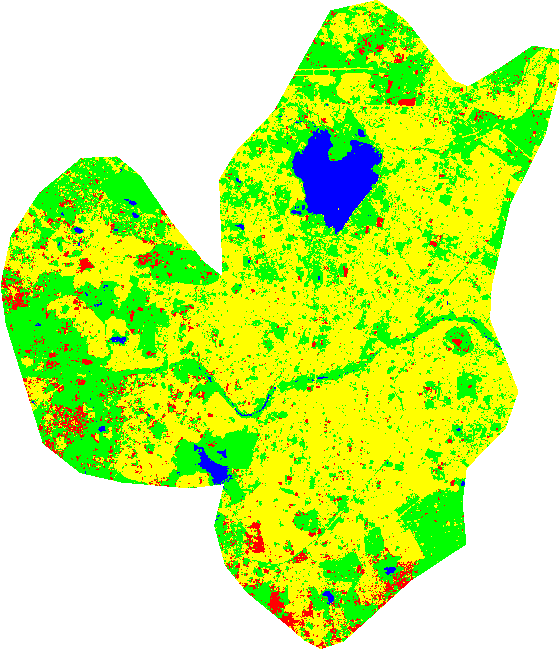

'Map for 2017 saved as: Hyderabad_Land_Cover_2017.html'


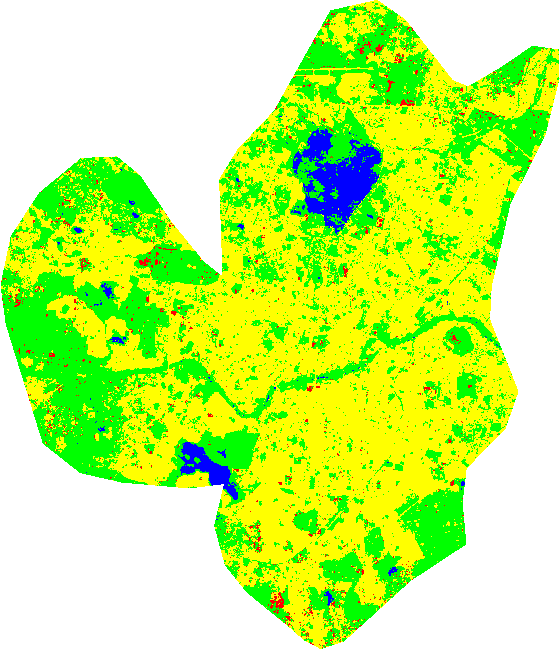

'Map for 2018 saved as: Hyderabad_Land_Cover_2018.html'


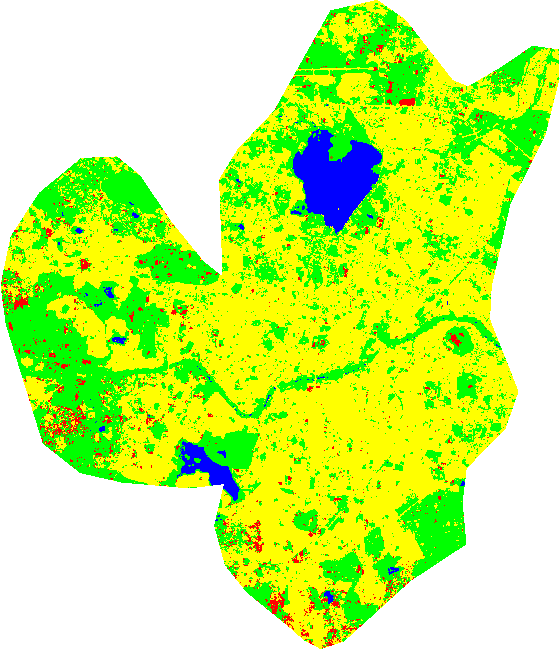

'Map for 2019 saved as: Hyderabad_Land_Cover_2019.html'


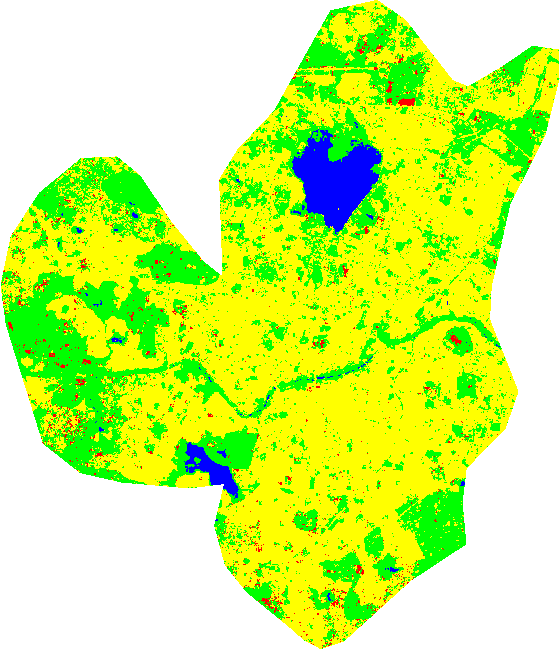

In [ ]:
import rasterio
import folium
import geemap
import numpy as np

# Define the file paths for each year's GeoTIFF file
geotiff_files = [
    '/content/drive/MyDrive/Hyderabad_prediction_2016.tif',
    '/content/drive/MyDrive/Hyderabad_prediction_2017.tif',
    '/content/drive/MyDrive/Hyderabad_prediction_2018.tif',
    '/content/drive/MyDrive/Hyderabad_prediction_2019.tif'
]

# Color map for different land cover classes
color_map = {
    0: (0, 0, 0, 0),      # No Data (transparent)
    1: (0, 255, 0, 1),    # Green for Vegetation
    2: (0, 0, 255, 1),    # Blue for Water
    3: (255, 255, 0, 1),  # Yellow for Barren Land
    4: (255, 0, 0, 1),    # Red for Built-up
}

# Function to map classification values to colors
def get_color(value):
    return color_map.get(value, (0, 0, 0, 0))

# Function to add classified raster layer to the map
def create_classified_map(geotiff_path, year):
    map_object = folium.Map(location=[17.3850, 78.4867], zoom_start=10)

    with rasterio.open(geotiff_path) as src:
        image = src.read(1)  # Read the first band

        # Normalize and map classification values to colors
        classification_layer = np.zeros((image.shape[0], image.shape[1], 4))
        for key, color in color_map.items():
            classification_layer[image == key] = color

        bounds = src.bounds
        folium.raster_layers.ImageOverlay(
            image=classification_layer,
            bounds=[[bounds.bottom, bounds.left], [bounds.top, bounds.right]],
            name=f'Hyderabad Land Cover {year}',
            opacity=0.6,
            interactive=True
        ).add_to(map_object)

    folium.LayerControl().add_to(map_object)
    return map_object

# Generate a separate map for each year, save as HTML, and display
for year, geotiff_path in zip([2016, 2017, 2018, 2019], geotiff_files):
    map_object = create_classified_map(geotiff_path, year)
    map_file = f'Hyderabad_Land_Cover_{year}.html'
    map_object.save(map_file)
    display(f'Map for {year} saved as: {map_file}')
    display(map_object)




In [ ]:
# Mount Google Drive to access files
from google.colab import drive
drive.mount('/content/drive')

import rasterio
import numpy as np
import folium
import geemap
import matplotlib.pyplot as plt

# File paths to your GeoTIFFs on Google Drive
geotiff_files = {
    2016: '/content/drive/MyDrive/Hyderabad_prediction_2016.tif',
    2017: '/content/drive/MyDrive/Hyderabad_prediction_2017.tif',
    2018: '/content/drive/MyDrive/Hyderabad_prediction_2018.tif',
    2019: '/content/drive/MyDrive/Hyderabad_prediction_2019.tif'
}

# Function to read GeoTIFFs using rasterio
def read_geotiff(file_path):
    with rasterio.open(file_path) as src:
        image = src.read(1)  # Read the first band
        transform = src.transform
    return image, transform


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


<ipython-input-13-4923aa4a595a>:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  'colormap': plt.cm.get_cmap('RdYlGn'),  # Red to green colormap


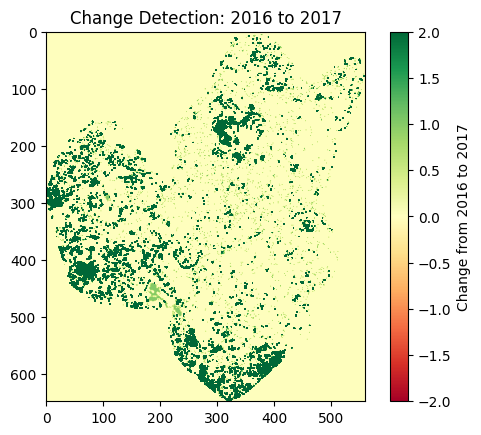

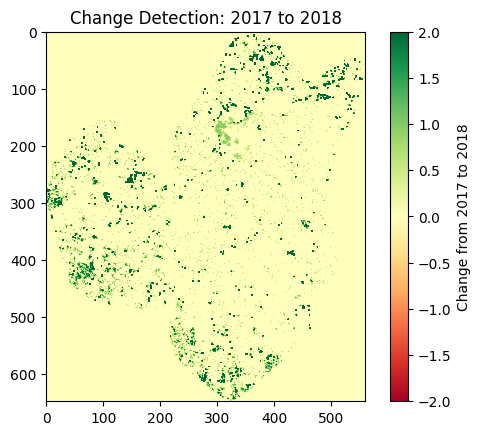

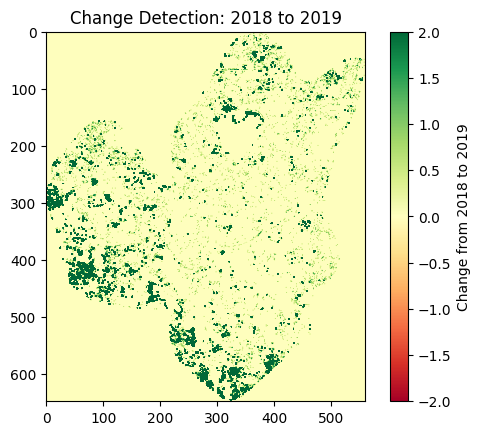

In [ ]:
# Create a map centered on Hyderabad
change_map = folium.Map(location=[17.3850, 78.4867], zoom_start=10)

# Define visualization parameters
vis_params = {
    'colormap': plt.cm.get_cmap('RdYlGn'),  # Red to green colormap
    'min': -2,
    'max': 2,
}

# Read and store GeoTIFFs in a dictionary
images = {}
transforms = {}
for year, path in geotiff_files.items():
    images[year], transforms[year] = read_geotiff(path)

# Compute and visualize changes between consecutive years
for year in range(2016, 2019):
    change = images[year + 1] - images[year]  # Calculate the change
    plt.imshow(change, cmap='RdYlGn', vmin=-2, vmax=2)
    plt.colorbar(label=f'Change from {year} to {year + 1}')
    plt.title(f'Change Detection: {year} to {year + 1}')
    plt.show()


'Combined map with layers saved as: Hyderabad_Land_Cover_Multi_Year.html'


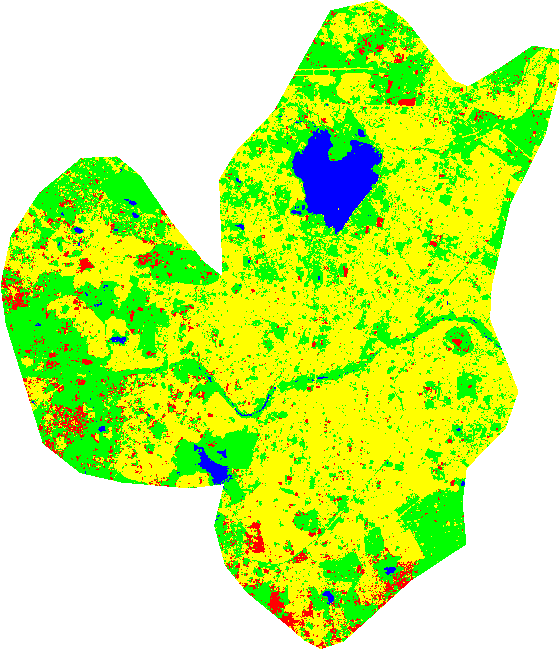
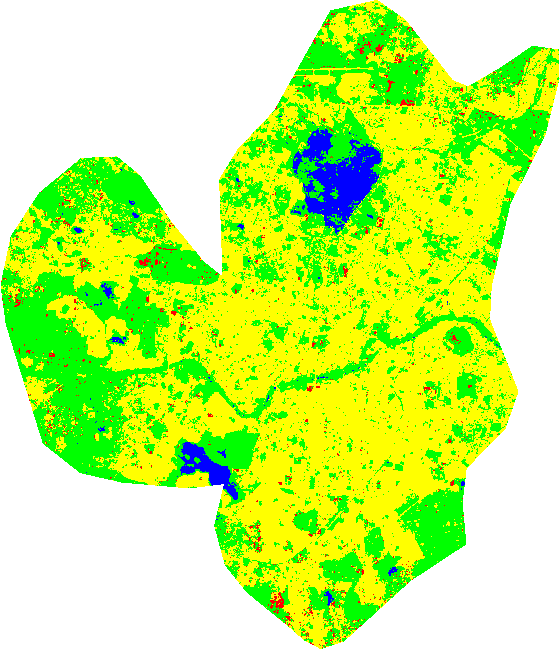
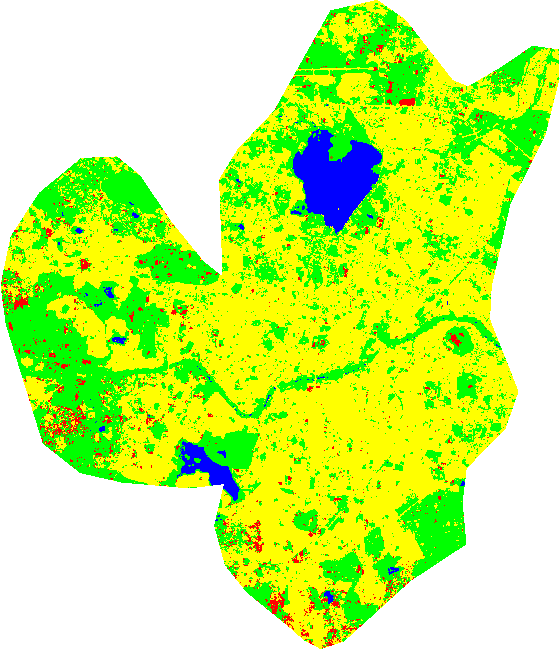
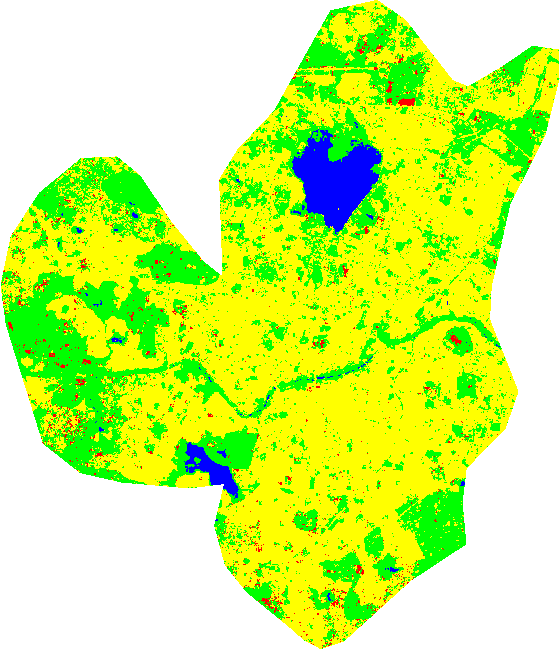

In [ ]:
!pip install rasterio
import rasterio
import folium
import numpy as np

# Define the file paths for each year's GeoTIFF file
geotiff_files = {
    2016: '/content/drive/MyDrive/Hyderabad_prediction_2016.tif',
    2017: '/content/drive/MyDrive/Hyderabad_prediction_2017.tif',
    2018: '/content/drive/MyDrive/Hyderabad_prediction_2018.tif',
    2019: '/content/drive/MyDrive/Hyderabad_prediction_2019.tif'
}

# Color map for different land cover classes
color_map = {
    0: (0, 0, 0, 0),      # No Data (transparent)
    1: (0, 255, 0, 255),  # Green for Vegetation
    2: (0, 0, 255, 255),  # Blue for Water
    3: (255, 255, 0, 255),# Yellow for Barren Land
    4: (255, 0, 0, 255)   # Red for Built-up
}

# Function to map classification values to colors
def get_color(value):
    return color_map.get(value, (0, 0, 0, 0))

# Initialize the map centered on Hyderabad
map_object = folium.Map(location=[17.3850, 78.4867], zoom_start=10)

# Function to add classified raster layer to the map as a layer for a specific year
def add_classified_layer(map_object, geotiff_path, year):
    with rasterio.open(geotiff_path) as src:
        image = src.read(1)  # Read the first band

        # Create an RGBA image with mapped colors
        classification_layer = np.zeros((image.shape[0], image.shape[1], 4), dtype=np.uint8)
        for key, color in color_map.items():
            classification_layer[image == key] = color

        # Define bounds for overlay
        bounds = [[src.bounds.bottom, src.bounds.left], [src.bounds.top, src.bounds.right]]

        # Add as an overlay with layer control
        folium.raster_layers.ImageOverlay(
            image=classification_layer,
            bounds=bounds,
            name=f'Hyderabad Land Cover {year}',
            opacity=0.6,
            interactive=True
        ).add_to(map_object)

# Add each year's classified map as a layer
for year, geotiff_path in geotiff_files.items():
    add_classified_layer(map_object, geotiff_path, year)

# Add layer control to toggle between years
folium.LayerControl().add_to(map_object)

# Save and display the map
map_file = 'Hyderabad_Land_Cover_Multi_Year.html'
map_object.save(map_file)
display(f'Combined map with layers saved as: {map_file}')
display(map_object)


In [ ]:
import rasterio
import numpy as np

# Define the file paths for each year's GeoTIFF file
geotiff_files = {
    '2016': '/content/drive/MyDrive/Hyderabad_prediction_2016.tif',
    '2017': '/content/drive/MyDrive/Hyderabad_prediction_2017.tif',
    '2018': '/content/drive/MyDrive/Hyderabad_prediction_2018.tif',
    '2019': '/content/drive/MyDrive/Hyderabad_prediction_2019.tif'
}

# Define the classes and initialize a dictionary to store results
classes = {
    1: 'Vegetation',
    2: 'Water',
    3: 'Barren Land',
    4: 'Built-up'
}

# Function to calculate the percentage coverage of each class
def calculate_coverage_percentage(geotiff_path, year):
    with rasterio.open(geotiff_path) as src:
        image = src.read(1)  # Read the first band
        total_pixels = image.size  # Total pixels in the image

        # Calculate the pixel count for each class
        coverage_percentages = {}
        for class_value, class_name in classes.items():
            class_pixels = np.sum(image == class_value)  # Count pixels for the class
            coverage_percentage = (class_pixels / total_pixels) * 100
            coverage_percentages[class_name] = coverage_percentage

    # Print results for this year
    print(f"\nCoverage Percentages for {year}:")
    for class_name, percentage in coverage_percentages.items():
        print(f"{class_name}: {percentage:.2f}%")

# Loop through each file and calculate the coverage percentages
for year, geotiff_path in geotiff_files.items():
    calculate_coverage_percentage(geotiff_path, year)



Coverage Percentages for 2016:
Vegetation: 21.19%
Water: 1.83%
Barren Land: 31.90%
Built-up: 2.76%

Coverage Percentages for 2017:
Vegetation: 21.81%
Water: 1.64%
Barren Land: 33.33%
Built-up: 0.90%

Coverage Percentages for 2018:
Vegetation: 19.93%
Water: 1.97%
Barren Land: 34.24%
Built-up: 1.55%

Coverage Percentages for 2019:
Vegetation: 18.11%
Water: 1.81%
Barren Land: 36.80%
Built-up: 0.96%
